# Project: Deep Learning for Food Image Recognition and Calorie Estimation

Course: Modern Analytics

Model made by: Team 42, Fuqua School of Business, Duke University.

Team members: Burhan Asad Dogar, Yubin Jeong, Ruiting Shao, Jessica Xiong, Moheed Zahid.

Date: 8 Dec 2025

# Libraries for set-up:

*   kagglehub: A library used to download datasets programmatically directly from Kaggle, eliminating the need for manual downloads or external drive mounting.
*   timm: A comprehensive collection of pretrained image models used for transfer learning.
*   albumentations: A fast image augmentation library used during training.

# Section A: Install dependencies

This section installs the necessary Python packages. Unlike previous workflows that might rely on mounting external storage, we simply install kagglehub and albumentations to handle data retrieval and processing directly within the notebook environment.

In [1]:
# A
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "Data_MA/nutrition v2.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "burhan222/data-ma",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("First 5 records:", df.head())

/tmp/ipython-input-3423472365.py:10: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


100%|██████████| 398/398 [00:00<00:00, 918kB/s]

First 5 records:           label  weight  calories  protein  carbohydrates  fats  fiber  \
0  caesar_salad     200       300       10             15    20      3   
1    cheesecake     100       350        6             30    22      1   
2        donuts      50       200        3             25    10      1   
3     dumplings     100       250        8             30    10      2   
4  french_toast     100       250        8             30    10      2   

   sugars  sodium  
0       5     500  
1      25     250  
2      12     150  
3       2     300  
4      10     300  


# Section B: Configuration and Auto-Split
First, we define the raw dataset path dynamically using kagglehub. The script calls kagglehub.dataset_download("burhan222/data-ma") to retrieve the data and assigns the resulting local path to the variable path. Based on this root directory, the script pre-defines three subfolders in a local working directory:


*   train/
*   val/
*   test/

These directories will be automatically created and populated during the dataset-splitting procedure, ensuring a clean and consistent project structure. In addition, an OUT_DIR folder is prepared for saving outputs such as logs, visualizations, and model checkpoints.

Second, we configure the dataset-splitting ratios along with several training-related hyperparameters. The dataset is divided following an 80/10/10 pattern for train/validation/test, and image files are copied rather than moved to preserve the integrity of the original source data. The script also initiates a warning if any class contains fewer than three images, since insufficient samples may affect training stability.

Training Hyperparameters:

*   Image size is fixed at 224 × 224

*   Batch size is set to 32

*   The first 3 epochs train only the classifier head (warm-up stage)

*   The subsequent 6 epochs fine-tune the entire model

*   Mixup augmentation is disabled by default

In [2]:
# B: CONFIG + auto-split (edit DRIVE_ROOT)

import os, random, shutil
import kagglehub # Added this so this cell works on its own

# Define the base path for the dataset using kagglehub
path = kagglehub.dataset_download("burhan222/data-ma")

# SMART PATH DETECTION
base_data_path = os.path.join(path, "Data_MA")

# Check if 'Data_MA' exists, otherwise fallback to the root path
if not os.path.exists(base_data_path):
    print(f"⚠️ 'Data_MA' folder not found. Checking root...")
    base_data_path = path

contents = os.listdir(base_data_path)

# Logic: If we see an 'images' folder, we dive in. Otherwise, assume we are there.
if "images" in contents and os.path.isdir(os.path.join(base_data_path, "images")):
    print(f"📂 Found 'images' subfolder. Setting root there.")
    RAW_ROOT = os.path.join(base_data_path, "images")
else:
    print(f"📂 Using class folders directly in: {base_data_path}")
    RAW_ROOT = base_data_path

# SET UP LOCAL WORKSPACE
WORK_DIR = "/content/dataset_ready"
TRAIN_ROOT = os.path.join(WORK_DIR, "train")
VAL_ROOT   = os.path.join(WORK_DIR, "val")
TEST_ROOT  = os.path.join(WORK_DIR, "test")
OUT_DIR = "/content/outputs"

os.makedirs(WORK_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

# split settings
SPLIT_RATIOS = (0.8, 0.1, 0.1)  # train, val, test
COPY_INSTEAD_OF_MOVE = True
MIN_PER_CLASS_WARN = 3
# training/hyperparams
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_EPOCHS_HEAD = 3
NUM_EPOCHS_FINE = 6
NUM_WORKERS = 4
USE_MIXUP = False
MIXUP_ALPHA = 0.4
# ---------------------------------------------------

def is_image_file(fn):
    return fn.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.webp'))

if not os.path.isdir(RAW_ROOT):
    raise RuntimeError(f"RAW_ROOT not found: {RAW_ROOT}. Mount Drive and set correct path.")

# if splits already exist and contain images, skip to avoid overwriting
def folder_has_images(p):
    return os.path.isdir(p) and any(is_image_file(f) for f in os.listdir(p))

if folder_has_images(TRAIN_ROOT) or folder_has_images(VAL_ROOT) or folder_has_images(TEST_ROOT):
    print("One of train/val/test already exists and contains images. Skipping auto-split.")
    print("If you want to re-split, delete/empty these and re-run this cell.")
else:
    # discover candidate class subfolders
    subdirs = [d for d in sorted(os.listdir(RAW_ROOT)) if os.path.isdir(os.path.join(RAW_ROOT, d)) and d not in ("train","val","test")]
    if len(subdirs) == 0:
        # flat images -> make 'uncategorized' folder
        imgs = [f for f in sorted(os.listdir(RAW_ROOT)) if is_image_file(f)]
        if len(imgs) == 0:
            raise RuntimeError(f"No images or class folders found under {RAW_ROOT}")
        temp = os.path.join(RAW_ROOT, "uncategorized")
        os.makedirs(temp, exist_ok=True)
        for f in imgs:
            s = os.path.join(RAW_ROOT, f); d = os.path.join(temp, f)
            if not os.path.exists(d):
                shutil.copy2(s, d)
        subdirs = ["uncategorized"]

    # create train/val/test dirs and copy files
    os.makedirs(TRAIN_ROOT, exist_ok=True)
    os.makedirs(VAL_ROOT, exist_ok=True)
    os.makedirs(TEST_ROOT, exist_ok=True)

    for cls in subdirs:
        src_dir = os.path.join(RAW_ROOT, cls)
        imgs = [f for f in sorted(os.listdir(src_dir)) if is_image_file(f)]
        random.shuffle(imgs)
        n = len(imgs)
        if n == 0:
            print(f"Skipping empty class: {cls}")
            continue
        if n < MIN_PER_CLASS_WARN:
            print(f"[warn] class {cls} has only {n} images (<{MIN_PER_CLASS_WARN})")
        n_train = int(round(n * SPLIT_RATIOS[0]))
        n_val   = int(round(n * SPLIT_RATIOS[1]))
        n_test  = n - n_train - n_val
        train_files = imgs[:n_train]
        val_files = imgs[n_train:n_train+n_val]
        test_files = imgs[n_train+n_val:]
        os.makedirs(os.path.join(TRAIN_ROOT, cls), exist_ok=True)
        os.makedirs(os.path.join(VAL_ROOT, cls), exist_ok=True)
        os.makedirs(os.path.join(TEST_ROOT, cls), exist_ok=True)
        for f in train_files:
            s = os.path.join(src_dir, f); d = os.path.join(TRAIN_ROOT, cls, f)
            if COPY_INSTEAD_OF_MOVE: shutil.copy2(s, d)
            else: shutil.move(s,d)
        for f in val_files:
            s = os.path.join(src_dir, f); d = os.path.join(VAL_ROOT, cls, f)
            if COPY_INSTEAD_OF_MOVE: shutil.copy2(s,d)
            else: shutil.move(s,d)
        for f in test_files:
            s = os.path.join(src_dir, f); d = os.path.join(TEST_ROOT, cls, f)
            if COPY_INSTEAD_OF_MOVE: shutil.copy2(s,d)
            else: shutil.move(s,d)
        print(f"Class {cls}: total={n}, train={len(train_files)}, val={len(val_files)}, test={len(test_files)}")

    print("Auto-split complete.")
    print("TRAIN_ROOT:", TRAIN_ROOT)
    print("VAL_ROOT:", VAL_ROOT)
    print("TEST_ROOT:", TEST_ROOT)


100%|██████████| 432M/432M [00:20<00:00, 22.1MB/s]

Extracting files...


📂 Using class folders directly in: /root/.cache/kagglehub/datasets/burhan222/data-ma/versions/1/Data_MA
Class caesar_salad: total=1000, train=800, val=100, test=100
Class cheesecake: total=1000, train=800, val=100, test=100
Class donuts: total=1000, train=800, val=100, test=100
Class dumplings: total=1000, train=800, val=100, test=100
Class french_toast: total=1000, train=800, val=100, test=100
Class macarons: total=1000, train=800, val=100, test=100
Class prime_rib: total=1000, train=800, val=100, test=100
Class ramen: total=1000, train=800, val=100, test=100
Class spaghetti_bolognese: total=1000, train=800, val=100, test=100
Auto-split complete.
TRAIN_ROOT: /content/dataset_ready/train
VAL_ROOT: /content/dataset_ready/val
TEST_ROOT: /content/dataset_ready/test


# Section C: Transforms, Dataset, and Loaders

This section accomplishes three key tasks:

1. Defining Data Pipelines: We specify two transformation flows. The training pipeline applies random resized cropping, horizontal flipping, rotation, brightness/contrast adjustments, and CoarseDropout to improve robustness. The validation pipeline uses consistent resizing, center cropping, and normalization for stable evaluation.

2. Building the Dataset: We implement a resilient custom Dataset that scans the directories created in Section B, filters corrupted files (via is_image_valid), and ensures consistent class ordering. It includes a fail-safe mechanism to retry loading images if a file is unreadable.

3. DataLoaders & Visualization: We create efficient DataLoaders using multi-worker loading and shuffling for training. Finally, a sanity-check visualization displays several validation images (de-normalized) to confirm correct loading and preprocessing.

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-2389251418.py:17: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=int(IMG_SIZE*0.12), max_width=int(IMG_SIZE*0.12), p=0.3),


Classes: ['caesar_salad', 'cheesecake', 'donuts', 'dumplings', 'french_toast', 'macarons', 'prime_rib', 'ramen', 'spaghetti_bolognese']
Train samples: 7200 Val samples: 900 Test samples: 900


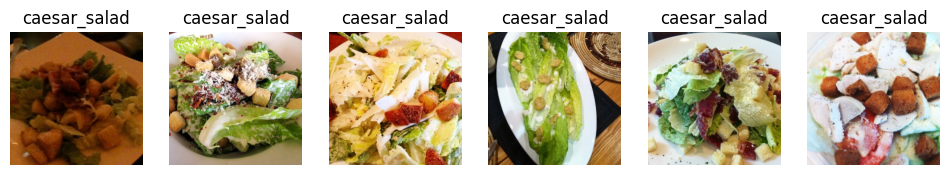

In [3]:
# C: transforms + robust dataset + dataloaders
import numpy as np
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
from torch.utils.data import Dataset, DataLoader
import os, random, matplotlib.pyplot as plt

# transforms
train_transform = A.Compose([
    A.RandomResizedCrop(size=(IMG_SIZE, IMG_SIZE), scale=(0.6,1.0)),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.4),
    A.RandomBrightnessContrast(p=0.5),
    A.CoarseDropout(max_holes=1, max_height=int(IMG_SIZE*0.12), max_width=int(IMG_SIZE*0.12), p=0.3),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2(),
])
val_transform = A.Compose([
    A.Resize(int(IMG_SIZE*1.14), int(IMG_SIZE*1.14)),
    A.CenterCrop(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2(),
])

# dataset
def is_image_valid(path):
    try:
        with Image.open(path) as im:
            im.verify()
        with Image.open(path) as im:
            im.convert('RGB')
        return True
    except Exception:
        return False

class ImagePathsDataset(Dataset):
    def __init__(self, root_dir, classes=None, transform=None, filter_corrupt=True):
        self.samples = []
        self.classes = []
        for cls in sorted(os.listdir(root_dir)):
            cls_dir = os.path.join(root_dir, cls)
            if os.path.isdir(cls_dir):
                self.classes.append(cls)
                for fn in sorted(os.listdir(cls_dir)):
                    if fn.lower().endswith(('.jpg','.jpeg','.png')):
                        p = os.path.join(cls_dir, fn)
                        self.samples.append((p, cls))
        if classes is not None:
            # enforce same class ordering as training
            self.classes = classes
        self.class_to_idx = {c:i for i,c in enumerate(self.classes)}
        self.samples = [(p, self.class_to_idx[c]) for p,c in self.samples if c in self.class_to_idx]
        self.transform = transform
        if filter_corrupt:
            bad = [p for p,_ in self.samples if not is_image_valid(p)]
            if bad:
                print(f"Warning: found {len(bad)} corrupt images; they will be skipped.")
            self.samples = [s for s in self.samples if is_image_valid(s[0])]

    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        p, lbl = self.samples[idx]
        for _ in range(3):
            try:
                img = np.array(Image.open(p).convert("RGB"))
                if self.transform:
                    img = self.transform(image=img)['image']
                return img, lbl
            except Exception:
                idx = random.randint(0, len(self.samples)-1)
        return torch.zeros(3, IMG_SIZE, IMG_SIZE), lbl

# create datasets and loaders
train_ds = ImagePathsDataset(TRAIN_ROOT, transform=train_transform)
val_ds = ImagePathsDataset(VAL_ROOT, classes=train_ds.classes, transform=val_transform)
test_ds = ImagePathsDataset(TEST_ROOT, classes=train_ds.classes, transform=val_transform) if os.path.isdir(TEST_ROOT) else None

classes = train_ds.classes
num_classes = len(classes)
print("Classes:", classes)
print("Train samples:", len(train_ds), "Val samples:", len(val_ds), "Test samples:", (len(test_ds) if test_ds else 0))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_workers = min(NUM_WORKERS, max(1, os.cpu_count()-1))
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers, pin_memory=(device.type=='cuda'))
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=(device.type=='cuda'))
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=(device.type=='cuda')) if test_ds else None

# quick sanity display
try:
    batch = next(iter(val_loader))
    imgs, labels = batch
    def imshow_tensor(t):
        t = t.numpy().transpose(1,2,0)
        mean = np.array([0.485,0.456,0.406]); std = np.array([0.229,0.224,0.225])
        img = np.clip(t * std + mean, 0, 1)
        plt.imshow(img); plt.axis('off')
    plt.figure(figsize=(12,4))
    for i in range(min(6, imgs.size(0))):
        plt.subplot(1,6,i+1); imshow_tensor(imgs[i].cpu()); plt.title(classes[labels[i].item()])
    plt.show()
except Exception as ex:
    print("Sanity display failed:", ex)


# Section D: Model Setup

This block prepares the transfer-learning setup. We load a pretrained ResNet18 and adapt it to our specific task by replacing the final fully connected layer (model.fc) to match our number of classes. We freeze the entire backbone initially to train only the new classifier head. We also configure the CrossEntropyLoss, an AdamW optimizer (targeting only the head), and optional mixed-precision scaling (GradScaler) for GPU efficiency.

In [4]:
# D: ResNet18 model setup (use torchvision pretrained weights)
import torch.nn as nn
from torchvision import models

# load pretrained ResNet18
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
in_feats = model.fc.in_features
model.fc = nn.Linear(in_feats, num_classes)   # replace classifier with our num_classes
model = model.to(device)

# freeze backbone initially, train head only
for p in model.parameters(): p.requires_grad = False
for p in model.fc.parameters(): p.requires_grad = True

import torch.optim as optim
criterion = nn.CrossEntropyLoss()
head_optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, weight_decay=1e-4)

# mixed precision scaler (if CUDA)
scaler = torch.cuda.amp.GradScaler() if device.type=='cuda' else None

print("Model ready:", model.__class__.__name__, "Num classes:", num_classes)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 219MB/s]

Model ready: ResNet Num classes: 9



/tmp/ipython-input-2846398387.py:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if device.type=='cuda' else None


# Section E: Head-Only Training

This block implements the head-only training loop.

accuracy_from_logits: Computes batch accuracy.

run_epoch: Handles one pass over the data. If train=True, it performs backpropagation and optimizer steps (with scaler support); otherwise, it evaluates in no_grad mode.

The outer loop runs for NUM_EPOCHS_HEAD epochs, prints loss/accuracy metrics, and saves a checkpoint (ckpt_head_best.pth) whenever validation loss improves.

In [5]:
# E: head training loop
import time
import os # Import os module to create directories

def accuracy_from_logits(out, t):
    return (out.argmax(dim=1) == t).float().mean().item()

def run_epoch(model, loader, optimizer=None, train=False):
    if train: model.train()
    else: model.eval()
    running_loss = 0.0; running_acc = 0.0; n = 0
    for imgs, labels in loader:
        imgs = imgs.to(device); labels = labels.to(device)
        if train:
            optimizer.zero_grad()
            if scaler:
                with torch.cuda.amp.autocast():
                    logits = model(imgs)
                    loss = criterion(logits, labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer); scaler.update()
            else:
                logits = model(imgs)
                loss = criterion(logits, labels)
                loss.backward(); optimizer.step()
        else:
            with torch.no_grad():
                logits = model(imgs)
                loss = criterion(logits, labels)
        bs = imgs.size(0)
        running_loss += loss.item() * bs
        running_acc += accuracy_from_logits(logits, labels) * bs
        n += bs
    return running_loss / max(1,n), running_acc / max(1,n)

best_val_loss = float('inf')
for e in range(1, NUM_EPOCHS_HEAD+1):
    t0 = time.time()
    tloss, tacc = run_epoch(model, train_loader, head_optimizer, train=True)
    vloss, vacc = run_epoch(model, val_loader, None, train=False)
    print(f"[HEAD] Epoch {e}/{NUM_EPOCHS_HEAD} time={(time.time()-t0):.1f}s train_loss={tloss:.4f} train_acc={tacc:.4f} val_loss={vloss:.4f} val_acc={vacc:.4f}")
    if vloss < best_val_loss - 1e-4:
        best_val_loss = vloss
        ckpt_path = os.path.join(OUT_DIR, "ckpt_head_best.pth")
        torch.save({"epoch": e, "state": model.state_dict(), "classes": classes}, ckpt_path)
        print("Saved head best:", ckpt_path)


/tmp/ipython-input-3670873550.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[HEAD] Epoch 1/3 time=9.8s train_loss=1.1321 train_acc=0.6637 val_loss=0.6562 val_acc=0.8144
Saved head best: /content/outputs/ckpt_head_best.pth
[HEAD] Epoch 2/3 time=8.0s train_loss=0.6306 train_acc=0.8119 val_loss=0.5466 val_acc=0.8267
Saved head best: /content/outputs/ckpt_head_best.pth
[HEAD] Epoch 3/3 time=8.2s train_loss=0.5582 train_acc=0.8303 val_loss=0.4824 val_acc=0.8556
Saved head best: /content/outputs/ckpt_head_best.pth


### Section F: Fine-Tuning and Validation

This section performs the full model fine-tuning:

1. Unfreeze: All model parameters are set to requires_grad = True.

2. Optimization: A new AdamW optimizer is created with a lower learning rate (3e-5), paired with a CosineAnnealingLR scheduler to decay the rate over NUM_EPOCHS_FINE.

3. Training Loop: The code runs the fine-tuning epochs, stepping the scheduler, tracking metrics, and saving the best checkpoint (ckpt_finetune_best.pth).

4. Final Save: The final model weights are saved to final_model.pth.

5. Validation: The model is evaluated on the validation set to generate a classification report (precision/recall/F1) and a confusion matrix to visualize per-class performance.

/tmp/ipython-input-3670873550.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[FINE] Epoch 1/6 train_loss=0.3946 train_acc=0.8771 val_loss=0.2943 val_acc=0.9144
Saved finetune best.
[FINE] Epoch 2/6 train_loss=0.2531 train_acc=0.9187 val_loss=0.2424 val_acc=0.9289
Saved finetune best.
[FINE] Epoch 3/6 train_loss=0.1903 train_acc=0.9383 val_loss=0.2256 val_acc=0.9289
Saved finetune best.
[FINE] Epoch 4/6 train_loss=0.1462 train_acc=0.9582 val_loss=0.2113 val_acc=0.9356
Saved finetune best.
[FINE] Epoch 5/6 train_loss=0.1159 train_acc=0.9683 val_loss=0.2085 val_acc=0.9311
Saved finetune best.
[FINE] Epoch 6/6 train_loss=0.1125 train_acc=0.9664 val_loss=0.2080 val_acc=0.9322
Saved finetune best.
Final model saved to /content/outputs/final_model.pth
Validation overall acc: 93.22%

Classification report (val):
                     precision    recall  f1-score   support

       caesar_salad       0.97      0.96      0.96       100
         cheesecake       0.93      0.90      0.91       100
             donuts       0.90      0.89      0.89       100
          dumpli

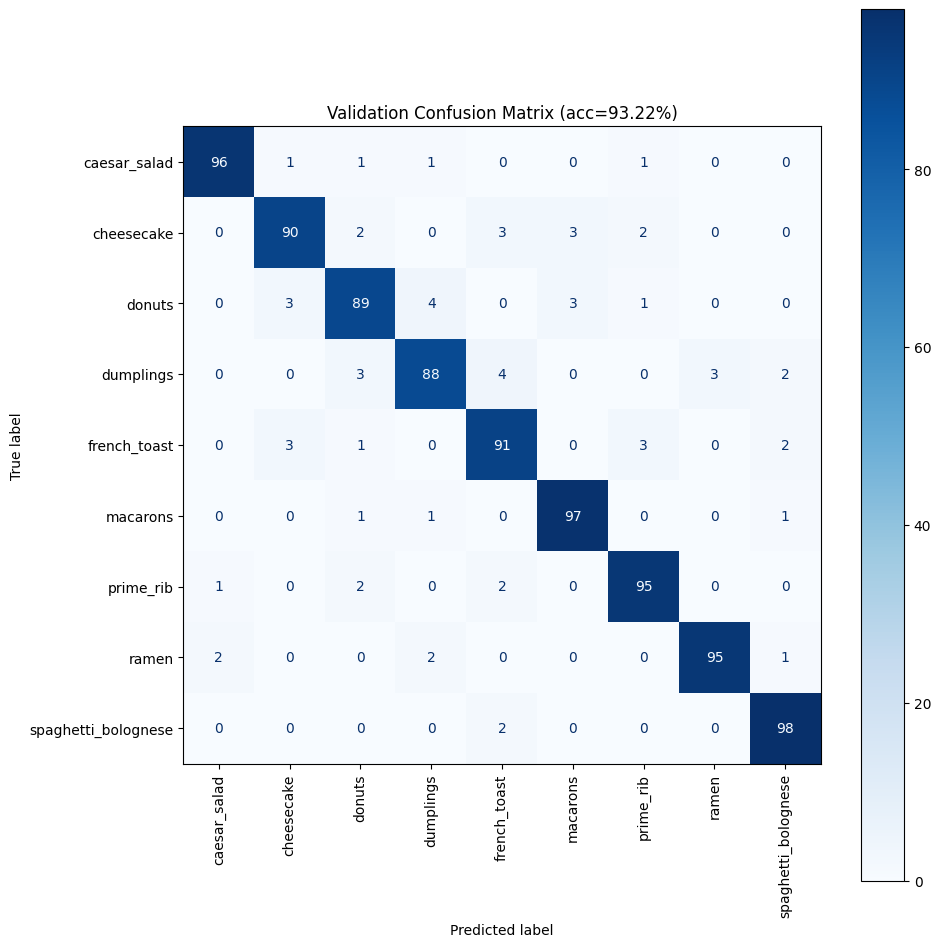

In [6]:
# F: Unfreeze + fine-tune, then validate and show confusion matrix (val only)
# Unfreeze whole model
for p in model.parameters(): p.requires_grad = True

fine_optimizer = optim.AdamW(model.parameters(), lr=3e-5, weight_decay=1e-4)
from torch.optim.lr_scheduler import CosineAnnealingLR
scheduler = CosineAnnealingLR(fine_optimizer, T_max=NUM_EPOCHS_FINE)

best_val_loss_ft = best_val_loss
for e in range(1, NUM_EPOCHS_FINE+1):
    tloss, tacc = run_epoch(model, train_loader, fine_optimizer, train=True)
    vloss, vacc = run_epoch(model, val_loader, None, train=False)
    scheduler.step()
    print(f"[FINE] Epoch {e}/{NUM_EPOCHS_FINE} train_loss={tloss:.4f} train_acc={tacc:.4f} val_loss={vloss:.4f} val_acc={vacc:.4f}")
    if vloss < best_val_loss_ft - 1e-4:
        best_val_loss_ft = vloss
        torch.save({"epoch": e, "state": model.state_dict(), "classes": classes}, os.path.join(OUT_DIR, "ckpt_finetune_best.pth"))
        print("Saved finetune best.")

# Save final model
torch.save({"state": model.state_dict(), "classes": classes}, os.path.join(OUT_DIR, "final_model.pth"))
print("Final model saved to", os.path.join(OUT_DIR, "final_model.pth"))

# VAL evaluation and confusion matrix
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model.eval()
y_true = []; y_pred = []; y_scores = []
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        outs = model(imgs)
        probs = torch.nn.functional.softmax(outs, dim=1).cpu().numpy()
        preds = probs.argmax(axis=1)
        y_scores.extend(probs.tolist())
        y_pred.extend(preds.tolist())
        y_true.extend(labels.numpy().tolist())

y_true = np.array(y_true); y_pred = np.array(y_pred)
val_acc = (y_true == y_pred).mean() if len(y_true)>0 else 0.0
print(f"Validation overall acc: {val_acc*100:.2f}%\n")
try:
    print("Classification report (val):")
    print(classification_report(y_true, y_pred, target_names=classes, zero_division=0))
except Exception as ex:
    print("Could not print classification report:", ex)

# confusion matrix (only if classes not huge)
if len(classes) <= 60:
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))
    fig, ax = plt.subplots(figsize=(10,10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(ax=ax, xticks_rotation='vertical', cmap='Blues')
    plt.title(f"Validation Confusion Matrix (acc={val_acc*100:.2f}%)")
    plt.tight_layout(); plt.show()
else:
    print(f"{len(classes)} classes — skip full confusion matrix display (too many classes).")

# Section G1: Test Set Preparation

This block prepares and validates the test dataset before final evaluation. It checks that the TEST_ROOT directory exists (raising an error if the split step wasn't run) and initializes the test_ds object. It ensures the test set is not empty and prints the total number of test samples available.

In [7]:
# G1: prepare test dataset
from PIL import Image
if not os.path.isdir(TEST_ROOT):
    raise RuntimeError(f"TEST_ROOT not found: {TEST_ROOT}. Run split step first.")
try:
    test_ds
except NameError:
    test_ds = ImagePathsDataset(TEST_ROOT, classes=train_ds.classes, transform=val_transform)
if len(test_ds) == 0:
    raise RuntimeError("No test images found.")
print("Test dataset ready. Samples:", len(test_ds))

Test dataset ready. Samples: 900


# Section G2: Load Nutrition Data

This section loads the nutrition reference table using the path provided by kagglehub.

The path to the CSV is constructed dynamically: os.path.join(path, "Data_MA", "nutrition v2.csv").

The CSV is read into a pandas DataFrame.

A new column _food_key is created by normalizing the labels (lowercase, stripped whitespace) to ensure consistent matching between model predictions and the database.

It confirms the data is loaded by printing the total row count.

In [8]:
# G2 Load nutrition CSV (SEAMLESS VERSION)
import pandas as pd
import os

# === CHANGE START: USE KAGGLE PATH INSTEAD OF DRIVE ===
# We use the 'path' variable from Block B
NUTRI_PATH = os.path.join(path, "Data_MA", "nutrition v2.csv")
# === CHANGE END ===

if not os.path.exists(NUTRI_PATH):
    print(f"⚠️ Could not find CSV at {NUTRI_PATH}")
    print("Listing Data_MA contents:", os.listdir(os.path.join(path, "Data_MA")))
else:
    # CSV
    df = pd.read_csv(NUTRI_PATH)

    print("Loaded nutrition table:")
    display(df.head())

    # Food name column cleaning
    df["_food_key"] = df["label"].astype(str).str.strip().str.lower()

    # nutrition v2 file column names
    name_col = "label"
    cal_col = "calories"

    print("\nNutrition file loaded successfully.")
    print(f"Total rows: {len(df)}")

Loaded nutrition table:


,label,weight,calories,protein,carbohydrates,fats,fiber,sugars,sodium
0,caesar_salad,200,300,10,15,20,3,5,500
1,cheesecake,100,350,6,30,22,1,25,250
2,donuts,50,200,3,25,10,1,12,150
3,dumplings,100,250,8,30,10,2,2,300
4,french_toast,100,250,8,30,10,2,10,300



Nutrition file loaded successfully.
Total rows: 9


# Section G3: Inference and Lookup

This final section demonstrates the model in action:

Inference: It selects a random image from the test set and uses predict_topk_for_path to get the top-k class probabilities.

Visualization: The image is plotted with its filename, true label, and predicted probabilities in the title.

Nutrition Lookup: The code takes the model's top-1 predicted class, normalizes the string, and looks up the corresponding nutritional information (Calories, Protein, Carbs, etc.) in the dataframe loaded in G2, printing the results to the console.

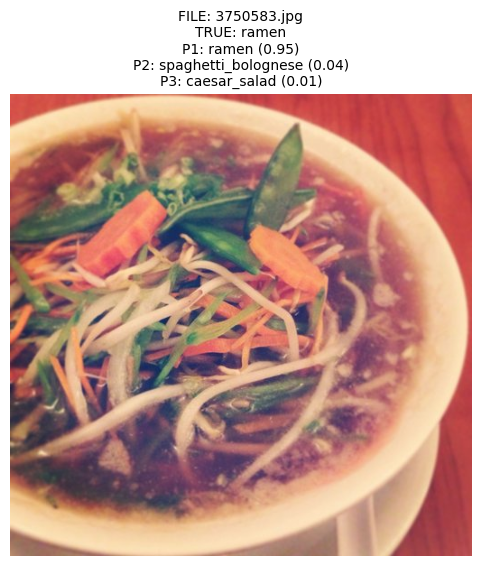

Path: /content/dataset_ready/test/ramen/3750583.jpg
True label: ramen
Top predictions:
  ramen: 95.12%
  spaghetti_bolognese: 4.24%
  caesar_salad: 0.53%

=== Nutrition info ===
Food: ramen
Calories: 400
Protein: 15
Carbohydrates: 60
Fats: 10
Fiber: 4
Sugars: 5
Sodium: 800


In [9]:
# G3 show one random test image and display model top-k predictions & true label
import random, numpy as np, matplotlib.pyplot as plt
from PIL import Image
random.seed()  # non-deterministic

TOPK = 3

def predict_topk_for_path(path, topk=TOPK):
    img = np.array(Image.open(path).convert("RGB"))
    inp = val_transform(image=img)['image'].unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        out = model(inp)
        probs = torch.nn.functional.softmax(out, dim=1).cpu().numpy()[0]
    idxs = list(np.argsort(probs)[::-1][:topk])
    return [(classes[i], float(probs[i])) for i in idxs], img

idx = random.randrange(len(test_ds))
path, true_idx = test_ds.samples[idx]
preds, img = predict_topk_for_path(path, topk=TOPK)

plt.figure(figsize=(6,6))
plt.imshow(img)
title = [f"FILE: {os.path.basename(path)}", f"TRUE: {classes[true_idx]}"]
for k,(lbl,prob) in enumerate(preds, start=1):
    title.append(f"P{k}: {lbl} ({prob:.2f})")
plt.title("\n".join(title), fontsize=10)
plt.axis('off')
plt.show()

print("Path:", path)
print("True label:", classes[true_idx])
print("Top predictions:")
for lbl,prob in preds:
    print(f"  {lbl}: {prob*100:.2f}%")

#Simple exact-match nutrition lookup (all nutrients except weight)

pred_label = preds[0][0]         # top-1 predicted label
key = pred_label.lower().strip()

row = df[df["_food_key"] == key]


r = row.iloc[0]

print("\n=== Nutrition info ===")
print(f"Food: {pred_label}")

nutrient_cols = ["calories", "protein", "carbohydrates", "fats", "fiber", "sugars", "sodium"]

for col in nutrient_cols:
    print(f"{col.capitalize()}: {r[col]}")


# Section H: Final Test Set Evaluation

This final block performs the definitive evaluation of the trained model. Up until this point, all performance metrics (like the 98.82% accuracy) were based on the validation set, which was used to tune hyperparameters and save checkpoints. To obtain an unbiased measure of real-world performance, we run the run_epoch function one last time on the Test Set (test_loader), which the model has never seen before. The resulting accuracy serves as the final "official" metric for the project's success.

In [10]:
# Final Evaluation on Test Set
print("Running final evaluation on Test Set...")
test_loss, test_acc = run_epoch(model, test_loader, None, train=False)
print(f"Final Test Set Accuracy: {test_acc*100:.2f}%")

Running final evaluation on Test Set...
Final Test Set Accuracy: 94.56%
